In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import scienceplots
#plt.style.use('science')

In [2]:
dt = 1e-15
t = np.arange(0, 5000e-15, dt)
nu_center = 0 #30e12
T2 = 500e-15
Q_t = np.exp(-t/T2)* np.cos(2*np.pi*nu_center*t)
Q_f = np.fft.fftshift(np.fft.fft(Q_t))
freqs = np.fft.fftshift(np.fft.fftfreq(len(t), dt))

In [3]:
df = freqs[1] - freqs[0]
norm_factor = np.sum(np.abs(Q_f)) * df
Q_f_norm = Q_f / norm_factor

In [4]:
#lorentzian fit
gamma = 1/(np.pi*T2)
Q_lorentzian_norm = (1/np.pi) * (gamma/2 / ((freqs - nu_center)**2 + (gamma/2)**2))
#Q_lorentzian_norm = Q_lorentzian / np.sum(Q_lorentzian) / df

c:\Users\dinus\OneDrive\Desktop\Python Physics\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\dinus\OneDrive\Desktop\Python Physics\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


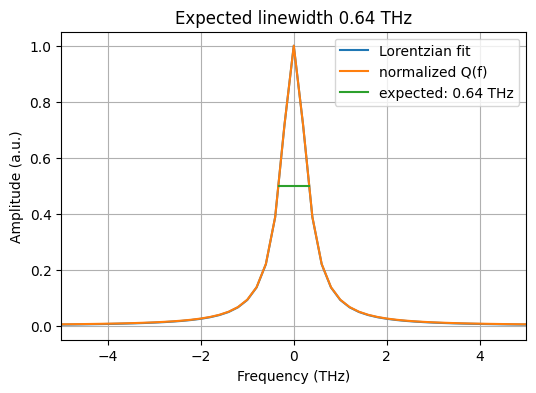

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
exp_lw= 1e-12/np.pi/T2 #(1e-12/np.pi/T2)/(3e10)
ax.plot(freqs*1e-12, Q_lorentzian_norm/np.max(Q_lorentzian_norm), label = 'Lorentzian fit')
ax.plot(freqs*1e-12, Q_f_norm/np.max(Q_f_norm), label = 'normalized Q(f)')
ax.plot([0-exp_lw/2, 0+exp_lw/2],[0.5,0.5],label=f'expected: {exp_lw:.2f} THz')
ax.set_xlim([-5,5])
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Amplitude (a.u.)')
ax.set_title(f'Expected linewidth {exp_lw:.2f} THz')
ax.grid()
ax.legend()
plt.show()

In [6]:
# now lets try our Q with all variable
# Define the Lorentzian function
def lorentzian(x, x0, a, gamma):
  return (a/np.pi) * (gamma/2 / ((x - x0)**2 + (gamma/2)**2))

def E(t, tau, omega):
    return np.exp(-2*np.log(2)*t**2/tau**2) * np.exp(-1j*omega*t)

def draw_line_width(ax, y, x, level=0.5, method = 'descrete'):
    line_width, left_pt, right_pt = 0, 0, 0
    #First do descrete method to get intitial parameters
    half_max = np.min(y) + level * (np.max(y)-np.min(y))
    indices = np.where(y >= half_max)[0]
    if len(indices) < 2:
        return None  # Not enough points above half max
    left_idx,right_idx = indices[0], indices[-1]
    line_width,left_pt, right_pt = x[right_idx] - x[left_idx],x[left_idx], x[right_idx]
    if method == 'lorentzian':
        # Fit the Lorentzian function to the noisy data
        popt, _ = curve_fit(lorentzian, x, y/np.max(y), p0=[0, 1, line_width]) # Initial guesses: [x0, a, gamma]
        fitted_x0, fitted_a, fitted_gamma = popt
        line_width,left_pt, right_pt = fitted_gamma, -fitted_gamma/2, fitted_gamma/2
    ax.annotate("", xy=(left_pt, half_max), xytext=(left_pt-line_width, half_max), arrowprops=dict(arrowstyle="->"))
    ax.annotate("", xy=(right_pt, half_max), xytext=(right_pt+line_width, half_max), arrowprops=dict(arrowstyle="->"))
    ax.text(right_pt+line_width, half_max, r"$\Delta\nu$="+f"{line_width:.2f} THz")
    return ax

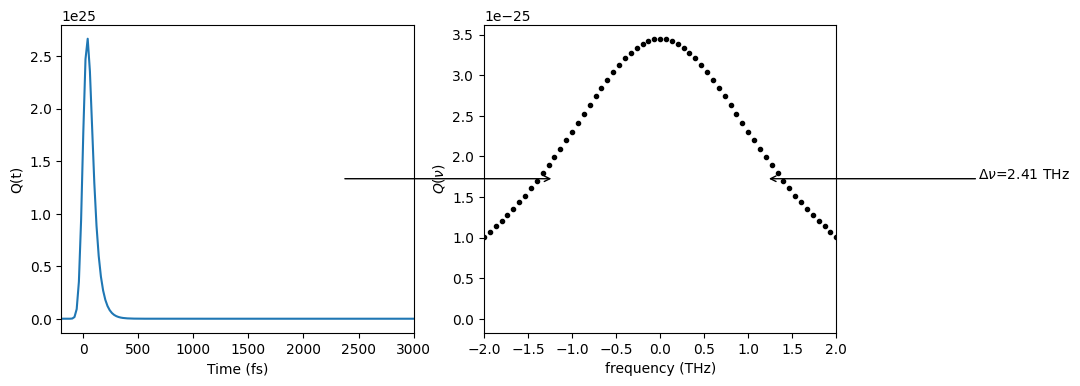

In [7]:
dt = 20e-15
T2 = 100e-15
tp_array = np.arange(-5000e-15, 10000e-15, dt)
tau = 100e-15
omega1,omega2 = 2*np.pi*3e8/1000e-9, 2*np.pi*3e8/1000e-9
int_part = np.array([],dtype=complex)
theta = np.arange(-5*tau, 5*tau, dt)
for tp in tp_array:
    int_val = np.trapezoid(E(theta, tau, omega1) * E(theta, tau, -omega2) * np.exp(theta/T2) * np.heaviside(tp-theta, 1), theta)
    int_part = np.append(int_part, int_val)
Q_t_full = np.exp(-tp_array/T2) * int_part
Q_t_norm = Q_t_full / np.trapezoid(Q_t_full, tp_array)

Q_f_full = np.fft.fftshift(np.fft.fft(Q_t_full))
freqs_full = np.fft.fftshift(np.fft.fftfreq(len(tp_array), dt))

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(tp_array*1e15, np.abs(Q_t_norm)**2)
ax[0].set_xlabel('Time (fs)')
ax[0].set_ylabel('Q(t)')
ax[0].set_xlim([-200,3000])
ax[1].plot(freqs_full*1e-12, np.abs(Q_f_full)**2, 'k.')
draw_line_width(ax[1], np.abs(Q_f_full)**2, freqs_full*1e-12, level=0.5, method='lorentzian')
ax[1].set_xlabel('frequency (THz)')
ax[1].set_ylabel(r'$Q(\nu)$')
ax[1].set_xlim(-2,2)
plt.show()

In [8]:
1e-12/np.pi/T2

3.1830988618379066